# 09 CNN을 활용한 이미지 인식

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from common_function import *

## 9.4 파이토치에서 CNN을 구현하는 방법

In [2]:
# nn.Cov2d(입력 채널수, 출력 채널수, 커널 사이즈)
conv1 = nn.Conv2d(3,32,3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32,32,3)
maxpool = nn.MaxPool2d((2,2))

In [3]:
print(conv1)

print(conv1.weight.shape)
print(conv1.bias.shape)

print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [4]:
# 입력용 더미 변수
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [5]:
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [6]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [7]:
# nn.Sequential
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [8]:
outputs = features(inputs)
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [9]:
# nn.Flatten
flatten = nn.Flatten()

outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.5 공통 함수 사용하기 - coommon_function.py에 구현함

## 9.6 데이터 준비

In [10]:
# Transform의 정의

# transform1 1계 텐서화

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
    transforms.Lambda(lambda x: x.view(-1))
])

# transform2 정규화만 실시

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

In [11]:
# 데이터 취득용 함수 datasets

data_root = './data'

# train dataset tensor(1)
train_set1 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform=transform1
)

# test dataset tensor(1)
test_set1 = datasets.CIFAR10(
    root = data_root, train=False,
    download=True, transform=transform1
)

# train dataset tensor(3)
train_set2 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform=transform2
)

# test dataset tensor(3)
test_set2 = datasets.CIFAR10(
    root = data_root, train=False,
    download=True, transform=transform2
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
# dataset check

image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [13]:
# define dataloader

batch_size = 100

train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [14]:
# check the data loader

for images1, labels1 in train_loader1:
    break

for images2, labels2 in train_loader2:
    break

print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


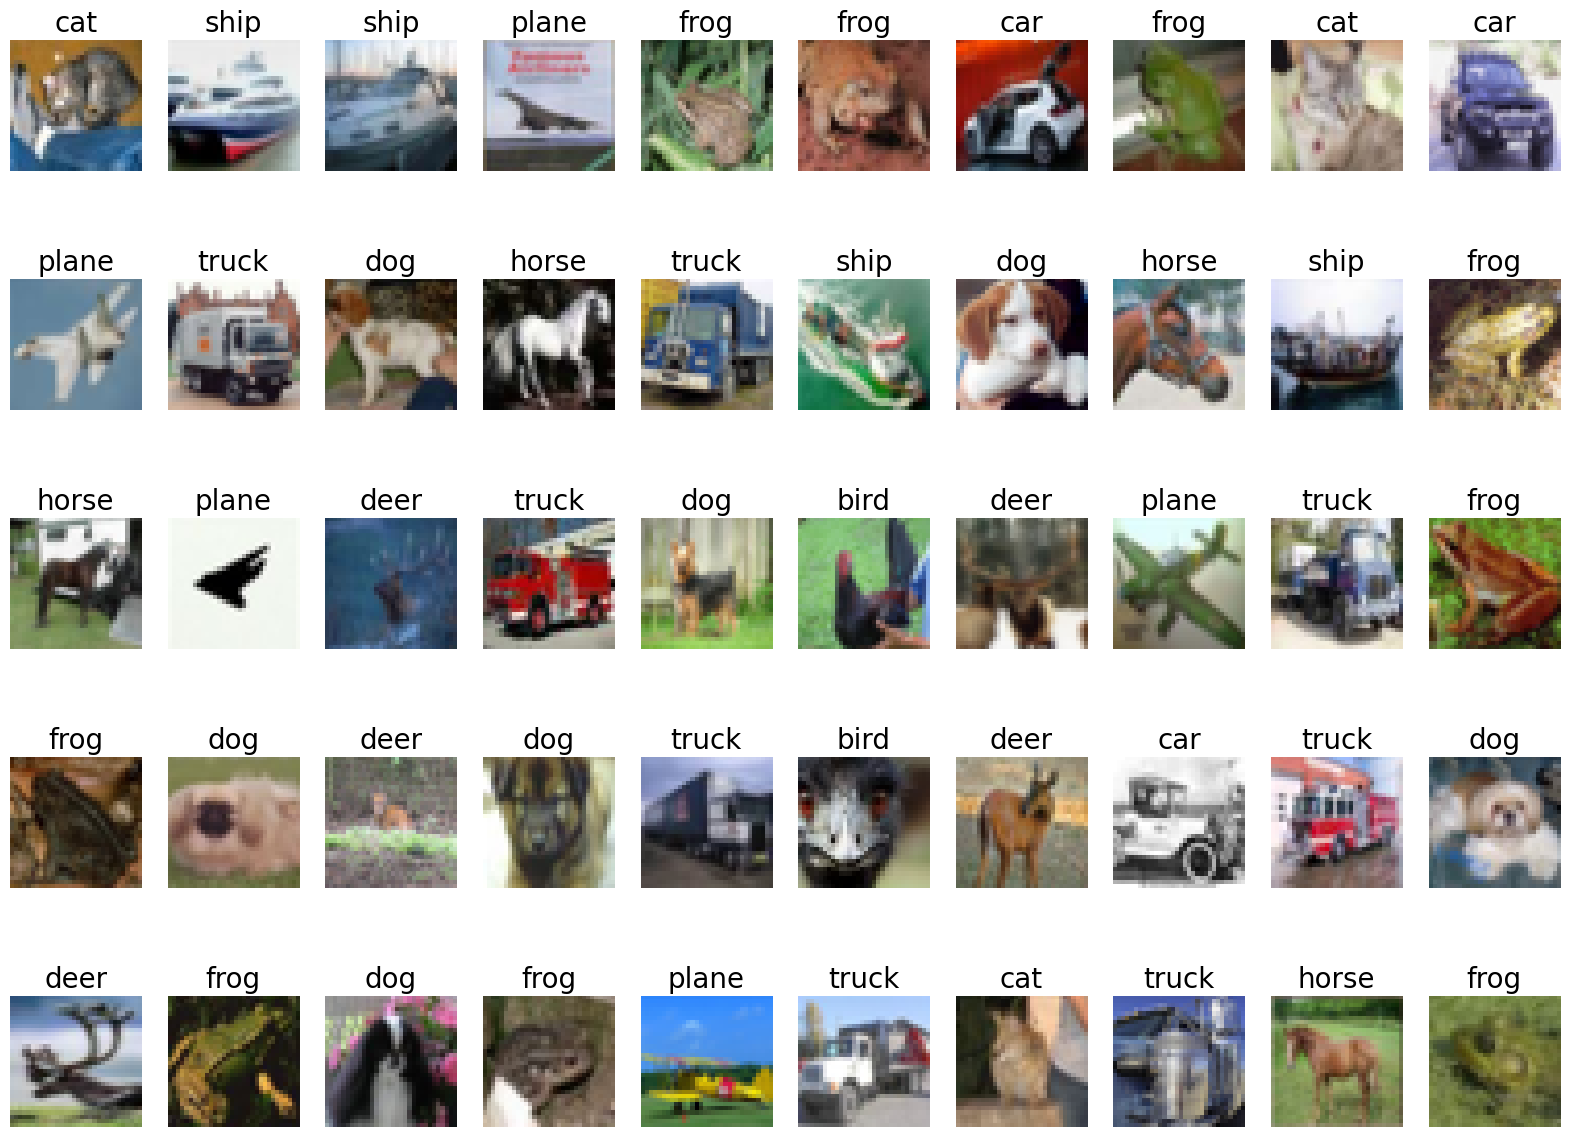

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog','frog','horse','ship','truck')

show_images_labels(test_loader2, classes, None, None)

## 9.7 모델 정의 (전결합형)

In [16]:
# 입력 차원수는 3*32*32 = 3072
n_input = image1.view(-1).shape[0]

# 출력 차원수 : 분류 클래스의 수이므로 10
n_output = len(set(list(labels1.data.numpy())))

# 은닉층의 노드수
n_hidden = 128

In [17]:
# 모델 정의
# 3072 입력층, 10 출력층, 1은닉층을 포함한 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

## 9.8 결과 확인 (전결합형)

In [18]:
# GPU 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 50

# 평가 결과 기록
history = np.zeros((0,5))

# 학습
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32218 val_loss: 0.01794, val_acc: 0.37710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39594 val_loss: 0.01684, val_acc: 0.41800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42404 val_loss: 0.01622, val_acc: 0.43840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44220 val_loss: 0.01583, val_acc: 0.45090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45522 val_loss: 0.01553, val_acc: 0.46190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46760 val_loss: 0.01530, val_acc: 0.46840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47686 val_loss: 0.01512, val_acc: 0.47420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48642 val_loss: 0.01493, val_acc: 0.47770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49586 val_loss: 0.01480, val_acc: 0.48630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50438 val_loss: 0.01463, val_acc: 0.48960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51134 val_loss: 0.01450, val_acc: 0.49730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.51992 val_loss: 0.01437, val_acc: 0.50270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52642 val_loss: 0.01425, val_acc: 0.50560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53506 val_loss: 0.01423, val_acc: 0.50550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53924 val_loss: 0.01407, val_acc: 0.51420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54578 val_loss: 0.01402, val_acc: 0.51130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55090 val_loss: 0.01390, val_acc: 0.51440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55700 val_loss: 0.01388, val_acc: 0.51410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01279 acc: 0.56248 val_loss: 0.01379, val_acc: 0.52060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56676 val_loss: 0.01381, val_acc: 0.51710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57124 val_loss: 0.01372, val_acc: 0.51640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01238 acc: 0.57714 val_loss: 0.01368, val_acc: 0.52420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58030 val_loss: 0.01363, val_acc: 0.52450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58384 val_loss: 0.01356, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01201 acc: 0.59114 val_loss: 0.01352, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01190 acc: 0.59300 val_loss: 0.01351, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59878 val_loss: 0.01350, val_acc: 0.52570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60248 val_loss: 0.01344, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60548 val_loss: 0.01343, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60944 val_loss: 0.01346, val_acc: 0.53220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61440 val_loss: 0.01341, val_acc: 0.52970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01125 acc: 0.61746 val_loss: 0.01338, val_acc: 0.52770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62052 val_loss: 0.01339, val_acc: 0.53190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62534 val_loss: 0.01342, val_acc: 0.52810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01096 acc: 0.62808 val_loss: 0.01341, val_acc: 0.52550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63170 val_loss: 0.01334, val_acc: 0.53220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01077 acc: 0.63474 val_loss: 0.01339, val_acc: 0.52860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01068 acc: 0.63870 val_loss: 0.01336, val_acc: 0.53120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64176 val_loss: 0.01341, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01051 acc: 0.64474 val_loss: 0.01348, val_acc: 0.52240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64926 val_loss: 0.01340, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65134 val_loss: 0.01347, val_acc: 0.52910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65322 val_loss: 0.01345, val_acc: 0.52450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01017 acc: 0.65570 val_loss: 0.01346, val_acc: 0.52690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65938 val_loss: 0.01345, val_acc: 0.52590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01001 acc: 0.66238 val_loss: 0.01344, val_acc: 0.52950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66432 val_loss: 0.01348, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00985 acc: 0.66848 val_loss: 0.01350, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67068 val_loss: 0.01364, val_acc: 0.52070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00971 acc: 0.67236 val_loss: 0.01352, val_acc: 0.53010


초기상태 : 손실 : 0.01794  정확도 : 0.37710
최종상태 : 손실 : 0.01352  정확도 : 0.53010


c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from curre

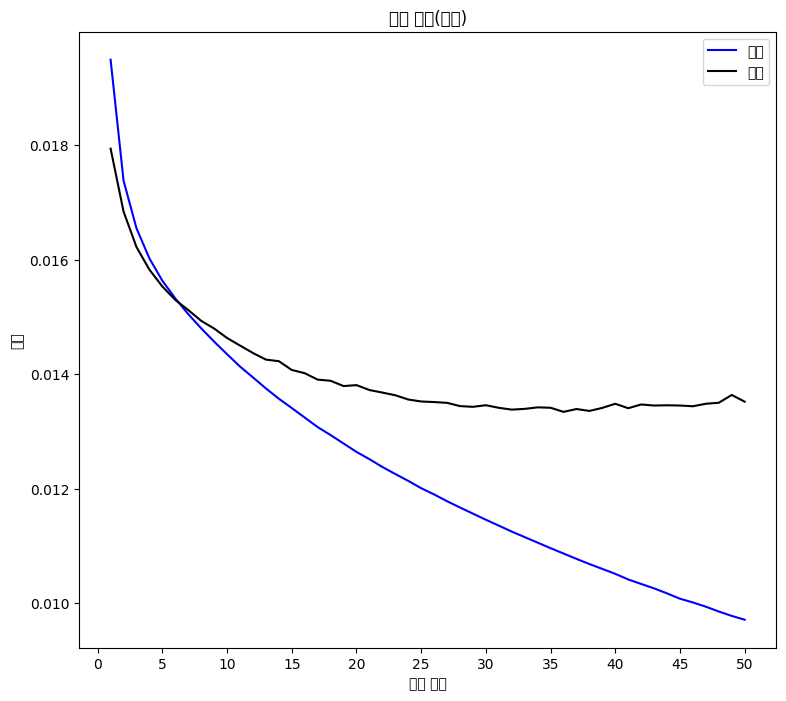

c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\saych\anaconda3\envs\diffusion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


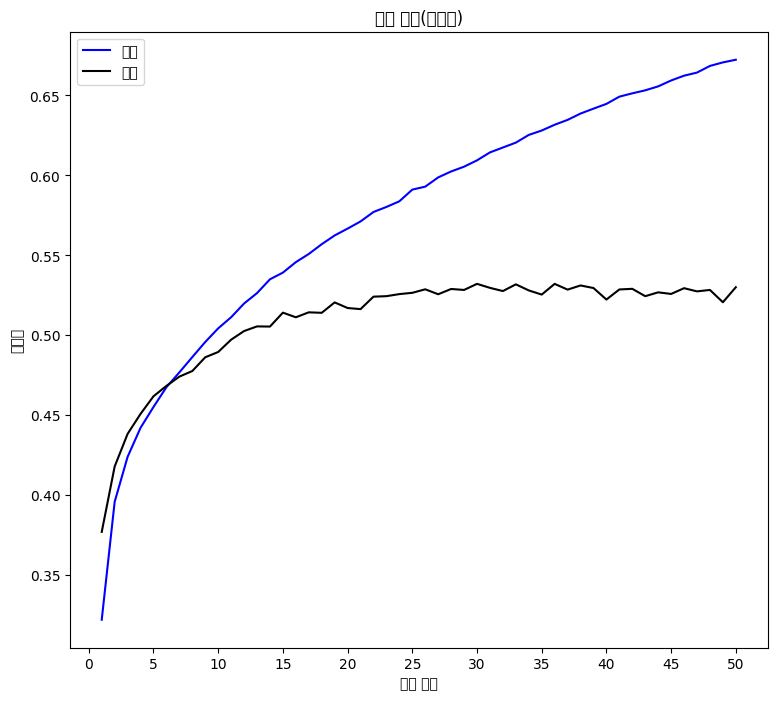

In [20]:
evaluate_history(history)

## 9.9 모델 정의 (CNN)

In [21]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv2 = nn.Conv2d(32,32,3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [22]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [23]:
summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

In [24]:
# 손실 계산
loss = eval_loss(test_loader2, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## 9.10 결과 (CNN)

In [25]:
torch_seed()

net = CNN(n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

num_epochs = 50

history2 = np.zeros((0,5))

history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02083 acc: 0.26110 val_loss: 0.01866, val_acc: 0.34670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37290 val_loss: 0.01677, val_acc: 0.40910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43062 val_loss: 0.01530, val_acc: 0.45970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47336 val_loss: 0.01450, val_acc: 0.48750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.50010 val_loss: 0.01369, val_acc: 0.51200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52088 val_loss: 0.01332, val_acc: 0.52670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53790 val_loss: 0.01290, val_acc: 0.54060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01252 acc: 0.55490 val_loss: 0.01251, val_acc: 0.55260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01204 acc: 0.57360 val_loss: 0.01235, val_acc: 0.56290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01157 acc: 0.59152 val_loss: 0.01182, val_acc: 0.58170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01116 acc: 0.60912 val_loss: 0.01163, val_acc: 0.58960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01077 acc: 0.62320 val_loss: 0.01171, val_acc: 0.58250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63636 val_loss: 0.01111, val_acc: 0.60510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00998 acc: 0.65064 val_loss: 0.01089, val_acc: 0.61340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66548 val_loss: 0.01113, val_acc: 0.60300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67720 val_loss: 0.01054, val_acc: 0.63170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00882 acc: 0.69322 val_loss: 0.01064, val_acc: 0.62350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00847 acc: 0.70384 val_loss: 0.01010, val_acc: 0.64720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00809 acc: 0.71944 val_loss: 0.01016, val_acc: 0.64410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00774 acc: 0.73060 val_loss: 0.01047, val_acc: 0.63430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00739 acc: 0.74222 val_loss: 0.01005, val_acc: 0.65220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00702 acc: 0.75744 val_loss: 0.01013, val_acc: 0.65390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76692 val_loss: 0.00990, val_acc: 0.65780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00637 acc: 0.77990 val_loss: 0.00996, val_acc: 0.66090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79384 val_loss: 0.00997, val_acc: 0.66430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00568 acc: 0.80566 val_loss: 0.01046, val_acc: 0.64770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00540 acc: 0.81556 val_loss: 0.01068, val_acc: 0.65690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00508 acc: 0.82810 val_loss: 0.01104, val_acc: 0.64450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00473 acc: 0.83954 val_loss: 0.01058, val_acc: 0.66600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00441 acc: 0.85236 val_loss: 0.01097, val_acc: 0.65790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00408 acc: 0.86250 val_loss: 0.01128, val_acc: 0.66170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00379 acc: 0.87244 val_loss: 0.01143, val_acc: 0.65930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00352 acc: 0.88318 val_loss: 0.01126, val_acc: 0.66750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00322 acc: 0.89316 val_loss: 0.01231, val_acc: 0.65270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00292 acc: 0.90550 val_loss: 0.01288, val_acc: 0.64960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00269 acc: 0.91440 val_loss: 0.01314, val_acc: 0.64510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00237 acc: 0.92686 val_loss: 0.01273, val_acc: 0.66690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00216 acc: 0.93210 val_loss: 0.01316, val_acc: 0.66210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00191 acc: 0.94270 val_loss: 0.01366, val_acc: 0.66120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00170 acc: 0.95304 val_loss: 0.01409, val_acc: 0.65960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00145 acc: 0.96016 val_loss: 0.01576, val_acc: 0.64720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00123 acc: 0.96814 val_loss: 0.01557, val_acc: 0.65130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00114 acc: 0.97226 val_loss: 0.01561, val_acc: 0.65590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00088 acc: 0.98078 val_loss: 0.01619, val_acc: 0.65770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00136 acc: 0.97212 val_loss: 0.01626, val_acc: 0.66430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00059 acc: 0.99060 val_loss: 0.01703, val_acc: 0.66150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00044 acc: 0.99498 val_loss: 0.01709, val_acc: 0.66340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00034 acc: 0.99698 val_loss: 0.01768, val_acc: 0.66690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00028 acc: 0.99790 val_loss: 0.01837, val_acc: 0.66340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00024 acc: 0.99870 val_loss: 0.01878, val_acc: 0.66170


초기상태 : 손실 : 0.01866  정확도 : 0.34670
최종상태 : 손실 : 0.01878  정확도 : 0.66170


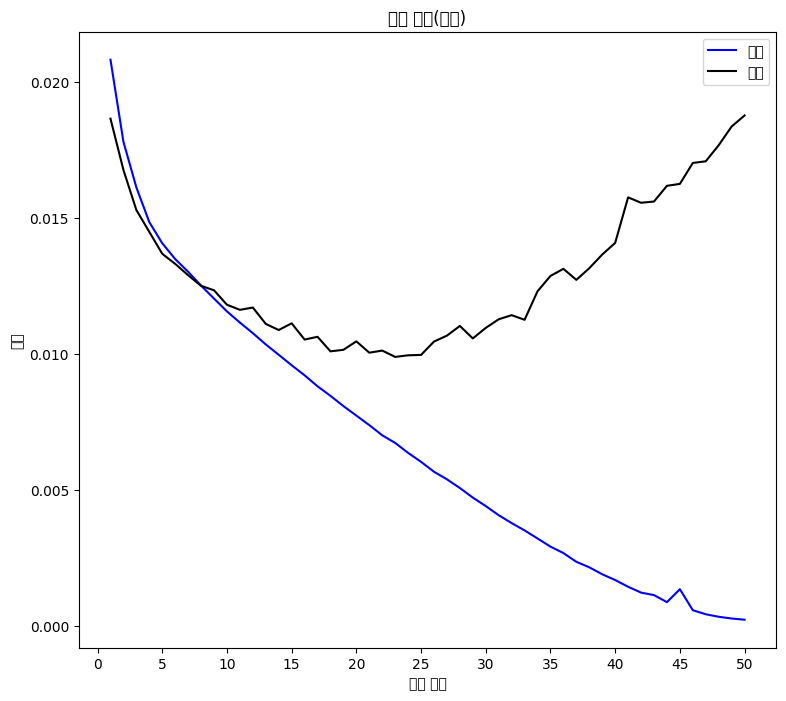

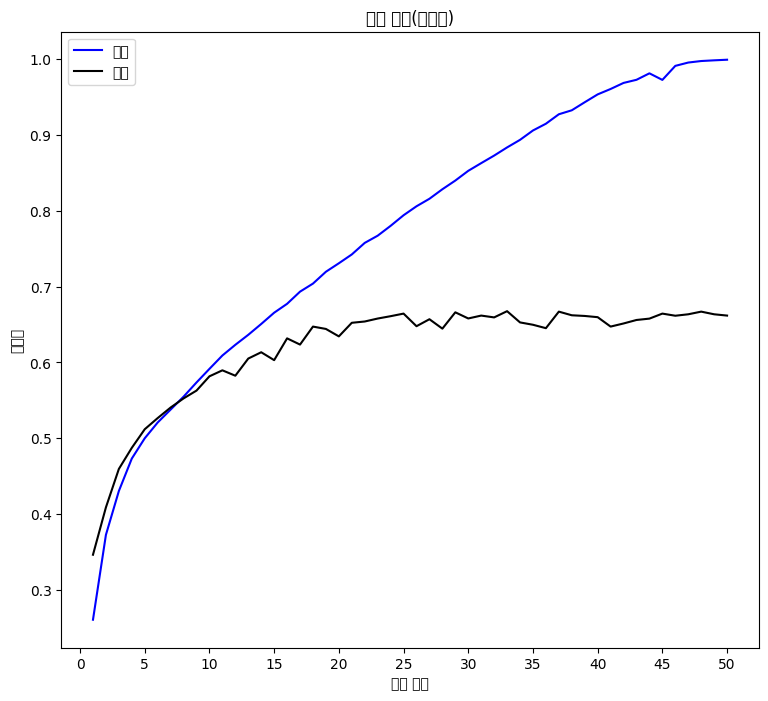

In [26]:
evaluate_history(history2)

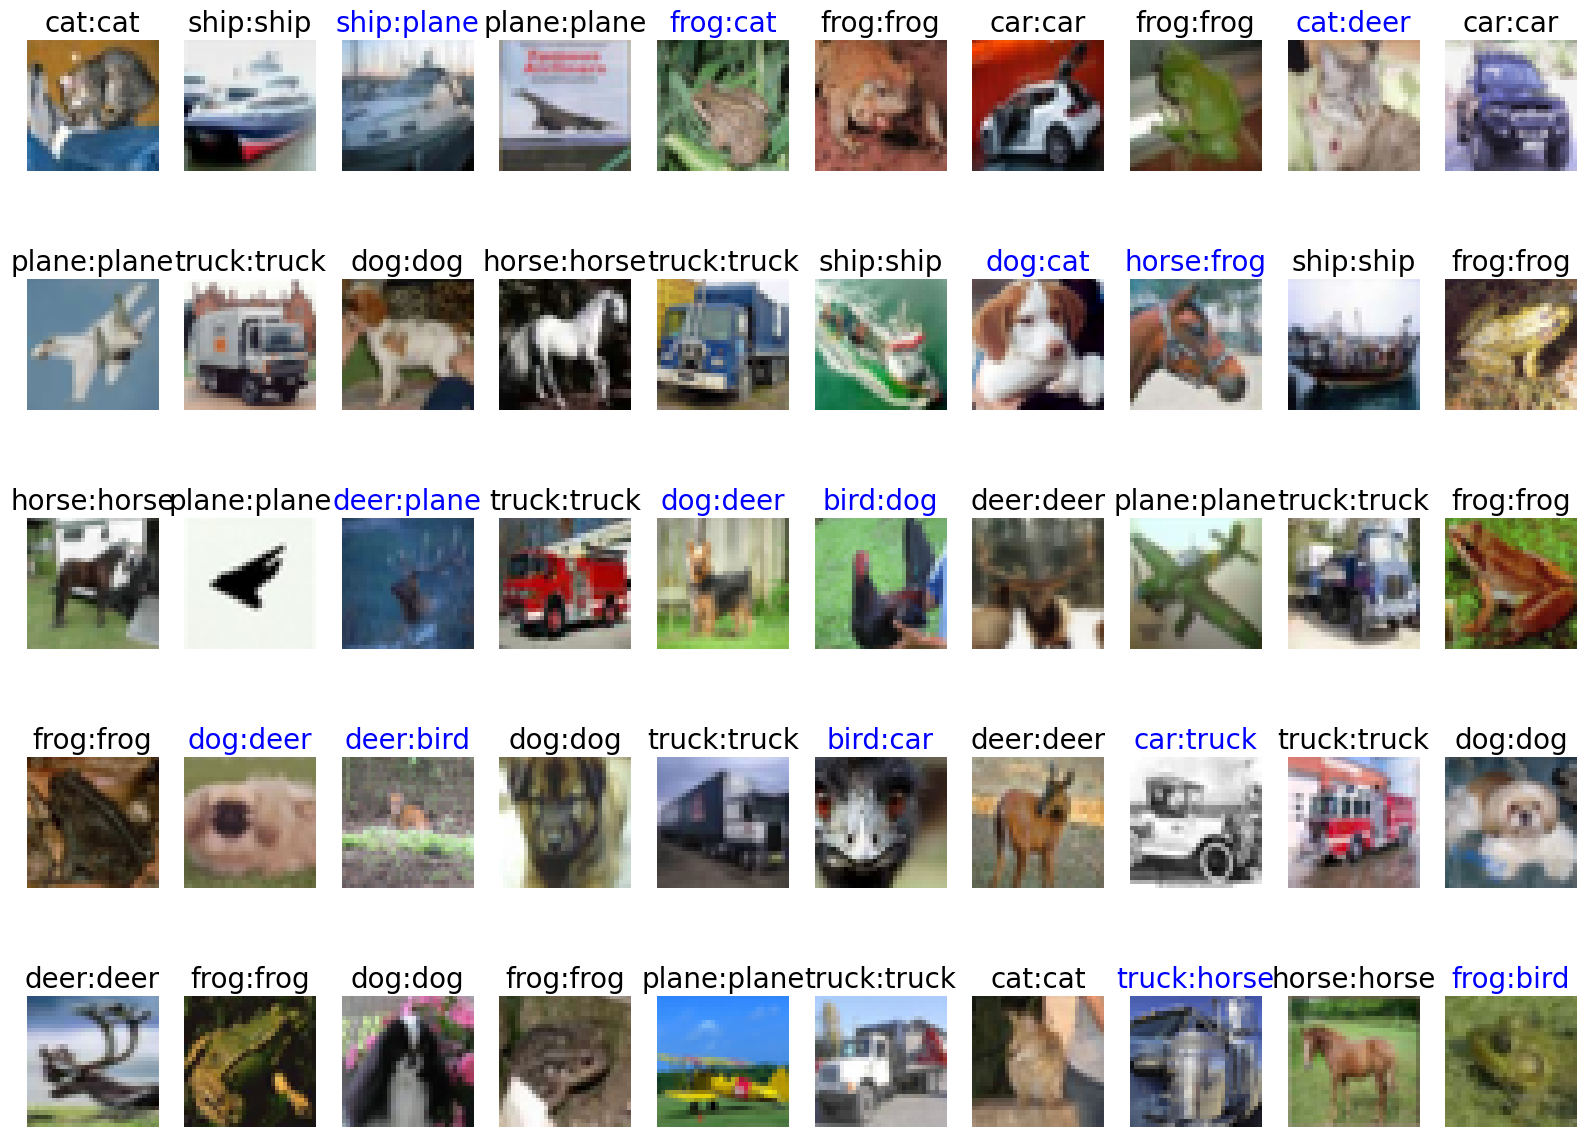

In [27]:
show_images_labels(test_loader2, classes, net, device)